In [35]:
import matplotlib as plt
import sklearn as sklearn
import scipy as scipy
import pandas as pd
import numpy as np
import copy

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import functions as fun


In [37]:
morpho_path = ".\AneuX\data-v1.0\data\morpho-per-cut.csv"
patient_path = ".\AneuX\data-v1.0\data\clinical.csv"
morpho_data = pd.read_csv(morpho_path)
patient_data = pd.read_csv(patient_path)

# Data Processing


In [38]:
morpho_data_reform = copy.deepcopy(morpho_data)
for i in morpho_data_reform:
    str_col = str(i) + "-" + str(morpho_data[i][0]) + "-" + str(morpho_data[i][1])
    #print(str_col)
    morpho_data_reform = morpho_data_reform.rename(columns={i: str_col})
   
morpho_data_reform = morpho_data_reform.rename(columns={"type-group-index": "source","Unnamed: 1-nan-nan": "dataset","Unnamed: 2-nan-nan": "cuttype"})
morpho_data_reform = morpho_data_reform.drop([0,1,2])

In [39]:
morpho_data_reform

,source,dataset,cuttype,curvature-gauss--L2N,curvature.1-gauss-H,curvature.2-gauss-L2N,curvature.3-gauss-L2NCH,curvature.4-mean--L2N,curvature.5-mean-H,curvature.6-mean-L2N,...,zmi_surf.131-energy-n11,zmi_surf.132-energy-n12,zmi_surf.133-energy-n13,zmi_surf.134-energy-n14,zmi_surf.135-energy-n15,zmi_surf.136-energy-n16,zmi_surf.137-energy-n17,zmi_surf.138-energy-n18,zmi_surf.139-energy-n19,zmi_surf.140-energy-n20
3,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.9761,35.9298,39.1894,41.5165,43.646,45.5701,47.4192,49.5589,52.4916,54.9455
4,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,cut2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.0238,43.9198,48.0721,51.9199,55.9642,60.8748,64.7821,68.2609,71.7461,74.6314
5,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,dome,0.725242,-0.0894094,2.60987,1.18701,0.198244,0.086614,1.86744,...,21.8387,23.5443,25.1746,26.6089,28.1611,30.1846,32.0237,33.6042,35.1063,37.0662
6,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,ninja,2.10899,0.214448,3.36637,1.46921,0.613297,0.297034,1.9215,...,23.3393,25.1042,27.0875,29.0246,30.7369,32.396,34.5638,36.0719,37.9747,39.807
7,hug2016,p044_BBMdFxESDBMcEwcVBhMBExQC,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.627,31.2497,33.5454,36.5774,38.9036,42.1663,44.2741,46.3791,47.4028,49.1238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,aneurisk,C0098,ninja,4.02451,-1.3277,6.76148,1.58789,0.700816,-0.445498,2.39925,...,23.1228,25.7898,27.9482,29.7224,30.7486,32.908,35.3017,36.9199,38.3504,40.132
2835,aneurisk,C0099,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.4355,30.5303,32.5532,34.6148,37.0667,39.4508,42.9421,45,47.9252,50.0939
2836,aneurisk,C0099,cut2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.0988,39.3052,42.4451,44.0456,46.4855,48.4827,51.0062,53.8531,56.8737,60.1946
2837,aneurisk,C0099,dome,0.606894,0.0592102,1.77604,1.05955,0.0435289,-0.0156052,1.5576,...,21.0817,22.363,23.8675,25.7323,27.5145,29.1724,30.676,32.1221,33.7636,35.7248


In [40]:
morpho_data_patient = morpho_data_reform.merge(patient_data, left_on='dataset', right_on='dataset', how='left')
morpho_data_patient.drop(['source_y','patientID','vesselFileID','cutToShow',"hospital"], axis=1, inplace=True)
morpho_data_patient.dropna(subset=['status'], inplace=True)
morpho_data_patient = morpho_data_patient.reset_index(drop=True)


In [41]:
morpho_data_patient

,source_x,dataset,cuttype,curvature-gauss--L2N,curvature.1-gauss-H,curvature.2-gauss-L2N,curvature.3-gauss-L2NCH,curvature.4-mean--L2N,curvature.5-mean-H,curvature.6-mean-L2N,...,zmi_surf.136-energy-n16,zmi_surf.137-energy-n17,zmi_surf.138-energy-n18,zmi_surf.139-energy-n19,zmi_surf.140-energy-n20,status,location,side,sex,age
0,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.5701,47.4192,49.5589,52.4916,54.9455,unruptured,ICA oph,left,female,64.2
1,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,cut2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60.8748,64.7821,68.2609,71.7461,74.6314,unruptured,ICA oph,left,female,64.2
2,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,dome,0.725242,-0.0894094,2.60987,1.18701,0.198244,0.086614,1.86744,...,30.1846,32.0237,33.6042,35.1063,37.0662,unruptured,ICA oph,left,female,64.2
3,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,ninja,2.10899,0.214448,3.36637,1.46921,0.613297,0.297034,1.9215,...,32.396,34.5638,36.0719,37.9747,39.807,unruptured,ICA oph,left,female,64.2
4,hug2016,p044_BBMdFxESDBMcEwcVBhMBExQC,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.1663,44.2741,46.3791,47.4028,49.1238,unruptured,VA V4,left,female,72.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,aneurisk,C0098,ninja,4.02451,-1.3277,6.76148,1.58789,0.700816,-0.445498,2.39925,...,32.908,35.3017,36.9199,38.3504,40.132,ruptured,MCA bif,right,female,59.0
2772,aneurisk,C0099,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.4508,42.9421,45,47.9252,50.0939,unruptured,MCA bif,right,female,42.0
2773,aneurisk,C0099,cut2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.4827,51.0062,53.8531,56.8737,60.1946,unruptured,MCA bif,right,female,42.0
2774,aneurisk,C0099,dome,0.606894,0.0592102,1.77604,1.05955,0.0435289,-0.0156052,1.5576,...,29.1724,30.676,32.1221,33.7636,35.7248,unruptured,MCA bif,right,female,42.0


In [42]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()

encoded_data = enc.fit_transform(morpho_data_patient[['sex']])
#print(encoded_data)
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=enc.get_feature_names_out(['sex']))
merged_dataset = pd.concat([morpho_data_patient, encoded_df], axis=1)

encoded_data = enc.fit_transform(merged_dataset[['status']])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=enc.get_feature_names_out(['status']))
merged_dataset = pd.concat([merged_dataset, encoded_df], axis=1)

# encoded_data = enc.fit_transform(merged_dataset[['location']])
# encoded_df = pd.DataFrame(encoded_data.toarray(), columns=enc.get_feature_names_out(['location']))
# merged_dataset = pd.concat([merged_dataset, encoded_df], axis=1)

# encoded_data = enc.fit_transform(merged_dataset[['side']])
# encoded_df = pd.DataFrame(encoded_data.toarray(), columns=enc.get_feature_names_out(['side']))
# merged_dataset = pd.concat([merged_dataset, encoded_df], axis=1)

merged_dataset.drop(['sex'], axis=1, inplace=True)
merged_dataset.drop(['status'], axis=1, inplace=True)
merged_dataset.drop(['status_unruptured'], axis=1, inplace=True)
merged_dataset.drop(['location'], axis=1, inplace=True)
merged_dataset.drop(['side'], axis=1, inplace=True)
merged_dataset


,source_x,dataset,cuttype,curvature-gauss--L2N,curvature.1-gauss-H,curvature.2-gauss-L2N,curvature.3-gauss-L2NCH,curvature.4-mean--L2N,curvature.5-mean-H,curvature.6-mean-L2N,...,zmi_surf.135-energy-n15,zmi_surf.136-energy-n16,zmi_surf.137-energy-n17,zmi_surf.138-energy-n18,zmi_surf.139-energy-n19,zmi_surf.140-energy-n20,age,sex_female,sex_male,status_ruptured
0,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.646,45.5701,47.4192,49.5589,52.4916,54.9455,64.2,1.0,0.0,0.0
1,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,cut2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.9642,60.8748,64.7821,68.2609,71.7461,74.6314,64.2,1.0,0.0,0.0
2,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,dome,0.725242,-0.0894094,2.60987,1.18701,0.198244,0.086614,1.86744,...,28.1611,30.1846,32.0237,33.6042,35.1063,37.0662,64.2,1.0,0.0,0.0
3,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,ninja,2.10899,0.214448,3.36637,1.46921,0.613297,0.297034,1.9215,...,30.7369,32.396,34.5638,36.0719,37.9747,39.807,64.2,1.0,0.0,0.0
4,hug2016,p044_BBMdFxESDBMcEwcVBhMBExQC,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.9036,42.1663,44.2741,46.3791,47.4028,49.1238,72.7,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,aneurisk,C0098,ninja,4.02451,-1.3277,6.76148,1.58789,0.700816,-0.445498,2.39925,...,30.7486,32.908,35.3017,36.9199,38.3504,40.132,59.0,1.0,0.0,1.0
2772,aneurisk,C0099,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.0667,39.4508,42.9421,45,47.9252,50.0939,42.0,1.0,0.0,0.0
2773,aneurisk,C0099,cut2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.4855,48.4827,51.0062,53.8531,56.8737,60.1946,42.0,1.0,0.0,0.0
2774,aneurisk,C0099,dome,0.606894,0.0592102,1.77604,1.05955,0.0435289,-0.0156052,1.5576,...,27.5145,29.1724,30.676,32.1221,33.7636,35.7248,42.0,1.0,0.0,0.0


In [43]:
morpho_data_cut1 = merged_dataset[merged_dataset["cuttype"] == "cut1"]
morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)

morpho_data_cut1

C:\Users\eulershadow\AppData\Local\Temp\ipykernel_9680\1749799083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
C:\Users\eulershadow\AppData\Local\Temp\ipykernel_9680\1749799083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)


,writhe-original-H,writhe.1-original-mean,writhe.2-original-std,writhe.3-L1norm-H,writhe.4-L1norm-mean,writhe.5-L1norm-std,writhe.6-L2-H,writhe.7-L2-mean,writhe.8-L2-std,zmi_surf-0.0-0.0,...,zmi_surf.135-energy-n15,zmi_surf.136-energy-n16,zmi_surf.137-energy-n17,zmi_surf.138-energy-n18,zmi_surf.139-energy-n19,zmi_surf.140-energy-n20,age,sex_female,sex_male,status_ruptured
0,3.13602,0.686535,6.38481,-1.60037,0.330408,0.0534176,1.23964,6.05006,0.881166,0.891258,...,43.646,45.5701,47.4192,49.5589,52.4916,54.9455,64.2,1.0,0.0,0.0
4,2.28995,-0.123443,2.53599,-1.17942,0.312721,0.0778531,1.33947,4.88757,1.00908,1.071280,...,38.9036,42.1663,44.2741,46.3791,47.4028,49.1238,72.7,1.0,0.0,0.0
8,2.32917,-0.00466042,2.70505,-1.51013,0.212483,0.0667921,1.6863,5.88084,1.56453,1.435430,...,35.6309,37.6116,39.7437,41.7172,44.1529,45.8037,50.9,0.0,1.0,0.0
12,2.52705,-0.021154,3.17756,-1.49203,0.251283,0.0746368,1.82116,7.80336,1.92642,1.272820,...,38.4547,40.9813,43.2989,45.1772,47.5794,49.8087,47.3,1.0,0.0,1.0
16,2.98359,-0.395319,5.1354,-1.43807,0.349662,0.061156,1.167,5.40205,0.851545,0.822235,...,51.9063,55.152,58.0832,59.6127,60.9068,62.4867,47.3,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,1.87399,-0.00474863,1.65733,-1.17324,0.253628,0.0834412,1.42177,3.83603,1.08127,1.269270,...,33.1295,35.0355,37.64,40.1607,42.3614,43.8509,43.0,1.0,0.0,0.0
2760,1.5737,0.00373571,1.3765,-1.41009,0.218476,0.0835751,1.69978,5.23269,1.65098,1.378590,...,34.7983,37.8419,40.0753,41.8086,43.2362,45.5748,67.0,0.0,1.0,1.0
2764,2.46928,0.277979,3.02867,-1.34477,0.351678,0.0659528,1.2976,5.8804,0.980592,1.060260,...,39.9266,41.9626,44.2732,47.1096,50.0711,52.9587,84.0,1.0,0.0,1.0
2768,1.96354,0.0263473,1.87208,-1.51831,0.18834,0.0830219,1.7068,5.97952,2.06504,1.340760,...,35.7781,39.4211,40.5627,42.223,43.9946,46.1836,59.0,1.0,0.0,1.0


In [44]:
morpho_data_dome = merged_dataset[merged_dataset["cuttype"] == "dome"]
morpho_data_dome.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
morpho_data_dome

C:\Users\eulershadow\AppData\Local\Temp\ipykernel_9680\2907034240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_dome.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)


,curvature-gauss--L2N,curvature.1-gauss-H,curvature.2-gauss-L2N,curvature.3-gauss-L2NCH,curvature.4-mean--L2N,curvature.5-mean-H,curvature.6-mean-L2N,curvature.7-mean-L2NCH,gi-shape-AR,gi.1-shape-BF,...,zmi_surf.135-energy-n15,zmi_surf.136-energy-n16,zmi_surf.137-energy-n17,zmi_surf.138-energy-n18,zmi_surf.139-energy-n19,zmi_surf.140-energy-n20,age,sex_female,sex_male,status_ruptured
2,0.725242,-0.0894094,2.60987,1.18701,0.198244,0.086614,1.86744,1.08866,0.876819,1.27173,...,28.1611,30.1846,32.0237,33.6042,35.1063,37.0662,64.2,1.0,0.0,0.0
6,0.524537,-0.360007,2.159,1.15799,0.0966873,-0.10215,1.69953,1.04997,0.991997,1.27592,...,27.2715,28.7998,31.0452,32.5206,34.0207,35.5299,72.7,1.0,0.0,0.0
10,1.96624,-1.21471,5.05633,1.32342,0.382815,-0.363665,2.30735,1.12822,1.07643,1.84807,...,30.9718,33.1091,35.1017,36.6565,38.4389,40.3165,50.9,0.0,1.0,0.0
14,7.7887,-0.823071,12.3872,2.40789,1.01931,-0.0544958,3.12703,1.35978,2.61395,3.16959,...,33.5714,35.2654,37.352,39.6833,41.1798,43.012,47.3,1.0,0.0,1.0
18,0.997234,0.089572,3.13267,1.2543,0.217909,0.224675,2.01593,1.0945,1.65683,1.53188,...,33.6385,36.6105,37.7905,38.8626,40.1787,42.9034,47.3,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,0.721845,-0.296889,2.56924,1.28583,0.232378,-0.00342363,1.77134,1.08248,0.846195,1.21771,...,27.0863,28.7959,30.044,31.6594,33.5313,35.0494,43.0,1.0,0.0,0.0
2762,4.12822,-0.645817,6.74744,1.74333,0.647408,-0.0426904,2.48483,1.17665,1.22381,1.75334,...,30.977,32.9759,35.4072,37.0025,38.3394,40.0176,67.0,0.0,1.0,1.0
2766,2.58888,-0.0131127,3.83658,1.76325,0.585148,0.180077,2.00644,1.15457,1.62177,1.43968,...,31.0267,33.1905,35.183,37.068,38.5364,40.3243,84.0,1.0,0.0,1.0
2770,2.05335,-1.52289,5.4371,1.43257,0.520694,-0.527362,2.26569,1.13279,1.56048,1.5928,...,28.9163,30.6686,33.3345,34.573,35.9075,37.5832,59.0,1.0,0.0,1.0


In [45]:
morpho_data_cut1["status_ruptured"]

0       0.0
4       0.0
8       0.0
12      1.0
16      0.0
       ... 
2756    0.0
2760    1.0
2764    1.0
2768    1.0
2772    0.0
Name: status_ruptured, Length: 735, dtype: float64

In [46]:
class DataFrameSelector(BaseEstimator):
    
    def __init__(self, attribute_names):
        self.attribute_names= attribute_names
        
    def fit(self,X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

train_data_cat = copy.deepcopy(morpho_data_cut1)
train_data_cat.drop(["status_ruptured"], axis=1, inplace=True)
data_num = list(train_data_cat)
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#imputer = IterativeImputer(max_iter = 30, random_state=0)
num_pipeline= Pipeline([
    ('selector', DataFrameSelector(data_num)),
    ('imputer',SimpleImputer(strategy="mean")),
    ('stand_scalar',StandardScaler()),
])


full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline)
])

data_prepared = full_pipeline.fit_transform(train_data_cat)

In [47]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
target_data_copy = morpho_data_cut1["status_ruptured"].copy()

data_copy = morpho_data_cut1.copy()

train_set, test_set = train_test_split(data_copy , test_size= 0.2, random_state=42)

train_set_target = train_set["status_ruptured"].copy()
train_set.drop(("status_ruptured"),axis=1,inplace=True)

test_set_target = test_set["status_ruptured"].copy()
test_set.drop(("status_ruptured"),axis=1,inplace=True)

test_prepared = full_pipeline.fit_transform(test_set)
train_prepared = full_pipeline.fit_transform(train_set)

print(test_prepared)
print(test_set_target)

[[ 1.82336863  0.7138668   2.72771721 ...  0.74626659 -1.69364136
   1.69364136]
 [ 0.80259887 -0.92100481  0.54177751 ...  1.32177585  0.59044378
  -0.59044378]
 [-0.47417713  0.21719798 -0.56062672 ... -1.39021298 -1.69364136
   1.69364136]
 ...
 [ 1.03536006 -3.65045898  1.11940249 ...  0.11557152  0.59044378
  -0.59044378]
 [ 0.17692092 -0.52721941 -0.21353383 ... -0.87777323 -1.69364136
   1.69364136]
 [ 1.39889128  0.63663359  1.68199074 ...  0.84875454  0.59044378
  -0.59044378]]
2147    0.0
132     0.0
1100    1.0
792     0.0
768     0.0
       ... 
176     0.0
280     0.0
784     0.0
2198    1.0
2174    0.0
Name: status_ruptured, Length: 147, dtype: float64


In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def prediction_conv (list_pred, value = 0.5):
    list_result = []
    for i in list_pred:
        if i >= value:
            list_result.append(1)
        else:
            list_result.append(0)
    return list_result

def show_pred_cm(data_predictions, test_set_target):
    #cm = confusion_matrix(list(test_set_target), data_predictions)
    cm = fun.dim4_cm(list(test_set_target), data_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred Unrupture","Pred uncertain Unrupture","Pred uncertain Rupture","Pred Rupture"], yticklabels=["Real Unrupture"," Real Rupture"])

# OLS

OLS rmse: 0.5532833351724882
OLS accuracy: 0.6938775510204082


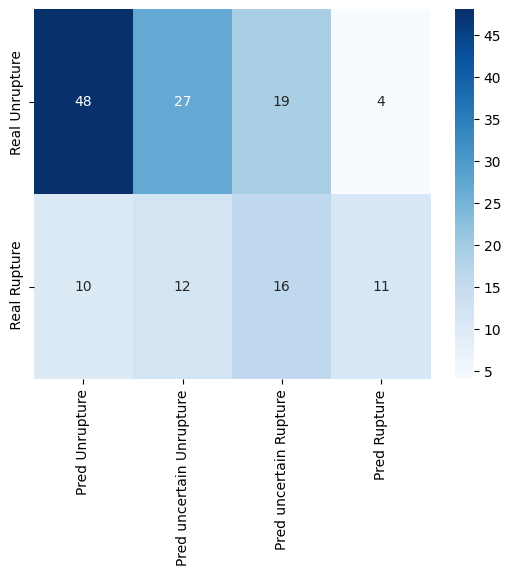

In [57]:

lin_reg=linear_model.LinearRegression()
lin_reg.fit(train_prepared,train_set_target)

data_predictions_raw = lin_reg.predict(test_prepared)
data_predictions = prediction_conv(data_predictions_raw,value=0.5)
data_mse=mean_squared_error(data_predictions, list(test_set_target))
data_rmse = np.sqrt(data_mse)
print("OLS rmse:",data_rmse)

show_pred_cm(data_predictions_raw, test_set_target)
accuracy = accuracy_score(data_predictions, test_set_target)
print("OLS accuracy:",accuracy)


# Lasso and Ridge linear Regression

Lasso best alpha: 0.02
[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
Lasso rmse: 0.5532833351724882
Lasso accuracy: 0.6938775510204082


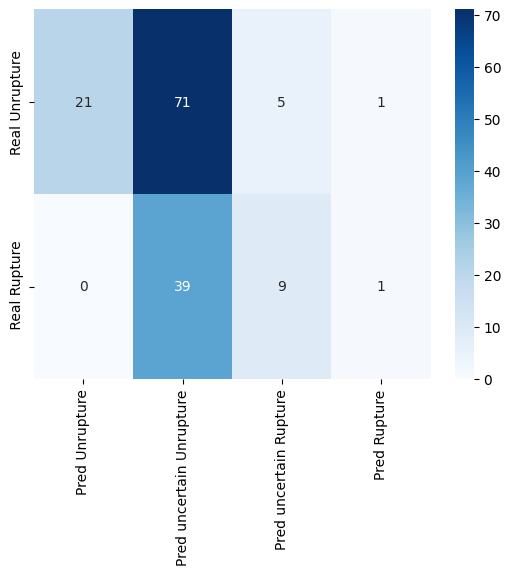

In [50]:
from sklearn.model_selection import GridSearchCV

#print(train_set_target)
model_cv = linear_model.LassoCV(alphas=list(np.arange(0.01,20,0.01)), cv=5).fit(train_prepared,train_set_target)
print("Lasso best alpha:",model_cv.alpha_)
las_reg_a = model_cv.alpha_
#las_reg_a = search.best_params_['model__alpha']
las_reg_a = 0.06

lasso_reg = linear_model.Lasso(alpha=las_reg_a)
lasso_reg.fit(train_prepared,train_set_target)

data_predictions_raw = lasso_reg.predict(test_prepared)
print(data_predictions)
data_predictions = prediction_conv(data_predictions_raw,value=0.5)
data_mse=mean_squared_error(data_predictions, list(test_set_target))
data_rmse = np.sqrt(data_mse)
print("Lasso rmse:",data_rmse)
show_pred_cm(data_predictions_raw, test_set_target)
accuracy = accuracy_score(data_predictions, test_set_target)
print("Lasso accuracy:",accuracy)


Ridge best alpha: 0.02
Ridge rmse: 0.5408484138857403
Ridge accuracy: 0.7074829931972789


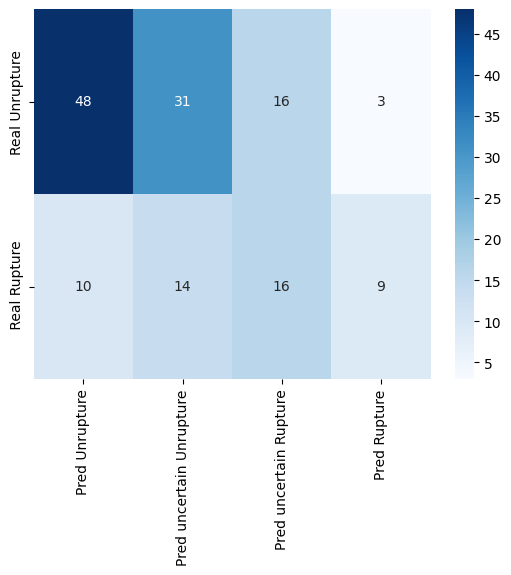

In [51]:
odel_cv = linear_model.RidgeCV(alphas=list(np.arange(0.1,100,0.1)), cv=5).fit(train_prepared,train_set_target)
print("Ridge best alpha:",model_cv.alpha_)
ridge_reg_a = model_cv.alpha_
ridge_reg_a =19.7

ridge_reg = linear_model.Ridge(alpha=ridge_reg_a)
ridge_reg.fit(train_prepared,train_set_target)

data_predictions_raw = ridge_reg.predict(test_prepared)
data_predictions = prediction_conv(data_predictions_raw,value=0.5)
data_mse=mean_squared_error(data_predictions, list(test_set_target))
data_rmse = np.sqrt(data_mse)
print("Ridge rmse:",data_rmse)

show_pred_cm(data_predictions_raw, test_set_target)
accuracy = accuracy_score(data_predictions, test_set_target)
print("Ridge accuracy:",accuracy)


# Logistic Regression

Logistic regression rmse: 0.5471012044321932
Logistic regression accuracy: 0.7006802721088435


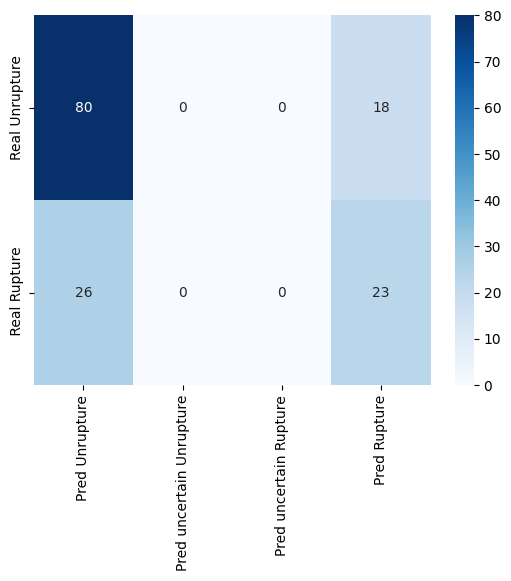

In [56]:
from sklearn.linear_model import LogisticRegression
#L1
logreg = LogisticRegression(penalty='l1', solver='liblinear')

logreg.fit(train_prepared,train_set_target)

data_predictions_raw = logreg.predict(test_prepared)

data_predictions = prediction_conv(data_predictions_raw)
data_mse=mean_squared_error(data_predictions, list(test_set_target))
data_rmse = np.sqrt(data_mse)
print("Logistic regression rmse:",data_rmse)

show_pred_cm(data_predictions_raw, test_set_target)
test_set_target = np.array(list(test_set_target))
accuracy = accuracy_score(data_predictions, test_set_target)
print("Logistic regression accuracy:",accuracy)

# Random Tree

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Random Tree regression rmse: 0.5345224838248488
Random Tree regression accuracy: 0.7142857142857143


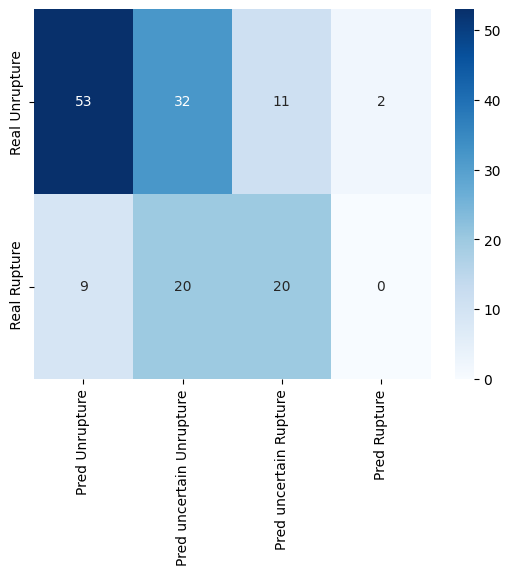

In [53]:

forest_reg=RandomForestRegressor()
#find estimator for random forest regression
param_grid  = [{'n_estimators': [470,430],'max_features':[1,23, 27]}, 
               {'bootstrap': [False],'n_estimators':[30],'max_features':[8]}]


grid_search = GridSearchCV(forest_reg, param_grid, cv=5,scoring='neg_mean_squared_error', verbose = 1)
grid_search.fit(train_prepared,train_set_target)

RT_prediction_raws = grid_search.predict(test_prepared)
data_predictions = prediction_conv(RT_prediction_raws,value=0.5)
data_mse=mean_squared_error(data_predictions, list(test_set_target))
data_rmse = np.sqrt(data_mse)
print("Random Tree regression rmse:",data_rmse)

show_pred_cm(RT_prediction_raws, test_set_target)
test_set_target = np.array(list(test_set_target))
accuracy = accuracy_score(data_predictions, test_set_target)
print("Random Tree regression accuracy:",accuracy)

# random forest

Random forest rmse: 0.5345224838248488
Random forest accuracy: 0.7142857142857143


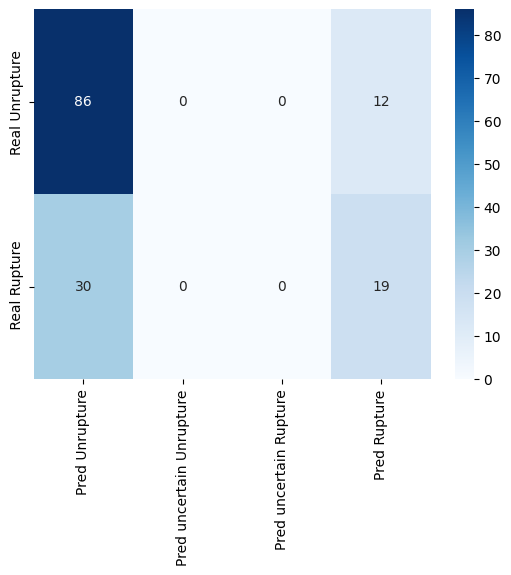

In [54]:
from sklearn.ensemble import RandomForestClassifier
forest_reg= RandomForestClassifier(n_estimators=100, random_state=42)
forest_reg.fit(train_prepared,train_set_target)

RT_predictions_raw = forest_reg.predict(test_prepared)
data_predictions = prediction_conv(RT_predictions_raw,value=0.5)
data_mse=mean_squared_error(data_predictions, list(test_set_target))
data_rmse = np.sqrt(data_mse)
print("Random forest rmse:",data_rmse)

show_pred_cm(RT_predictions_raw, test_set_target)
test_set_target = np.array(list(test_set_target))
accuracy = accuracy_score(data_predictions, test_set_target)
print("Random forest accuracy:",accuracy)